# Distribution DASK et AutoML

Utilisation du Framework Dask pour plusieurs tâches :
* Implémentation d'un grid search avec une régression logistique
* Modélisation XGBoost
* AutoML avec l'algo génétique TPOT

En complément, les prédictions du modèle XGBoost seront expliquées avec la méthode de Shapley (Shap)

## Déclaration du cluster local DASK

In [ ]:
from dask.distributed import Client
client = Client(n_workers=4, threads_per_worker=4)
client.cluster

## Import du jeu de données

In [ ]:
import dask.dataframe as dd

df = dd.read_csv('default_payment_2.csv', dtype={'BILL_AMT1': 'float64',
       'BILL_AMT2': 'float64',
       'BILL_AMT3': 'float64',
       'BILL_AMT4': 'float64',
       'BILL_AMT5': 'float64',
       'BILL_AMT6': 'float64',
       'PAY_AMT1': 'float64',
       'PAY_AMT2': 'float64',
       'PAY_AMT3': 'float64',
       'PAY_AMT4': 'float64',
       'PAY_AMT5': 'float64',
       'PAY_AMT6': 'float64'})

In [ ]:
stat = df.describe()

In [ ]:
stat.compute()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


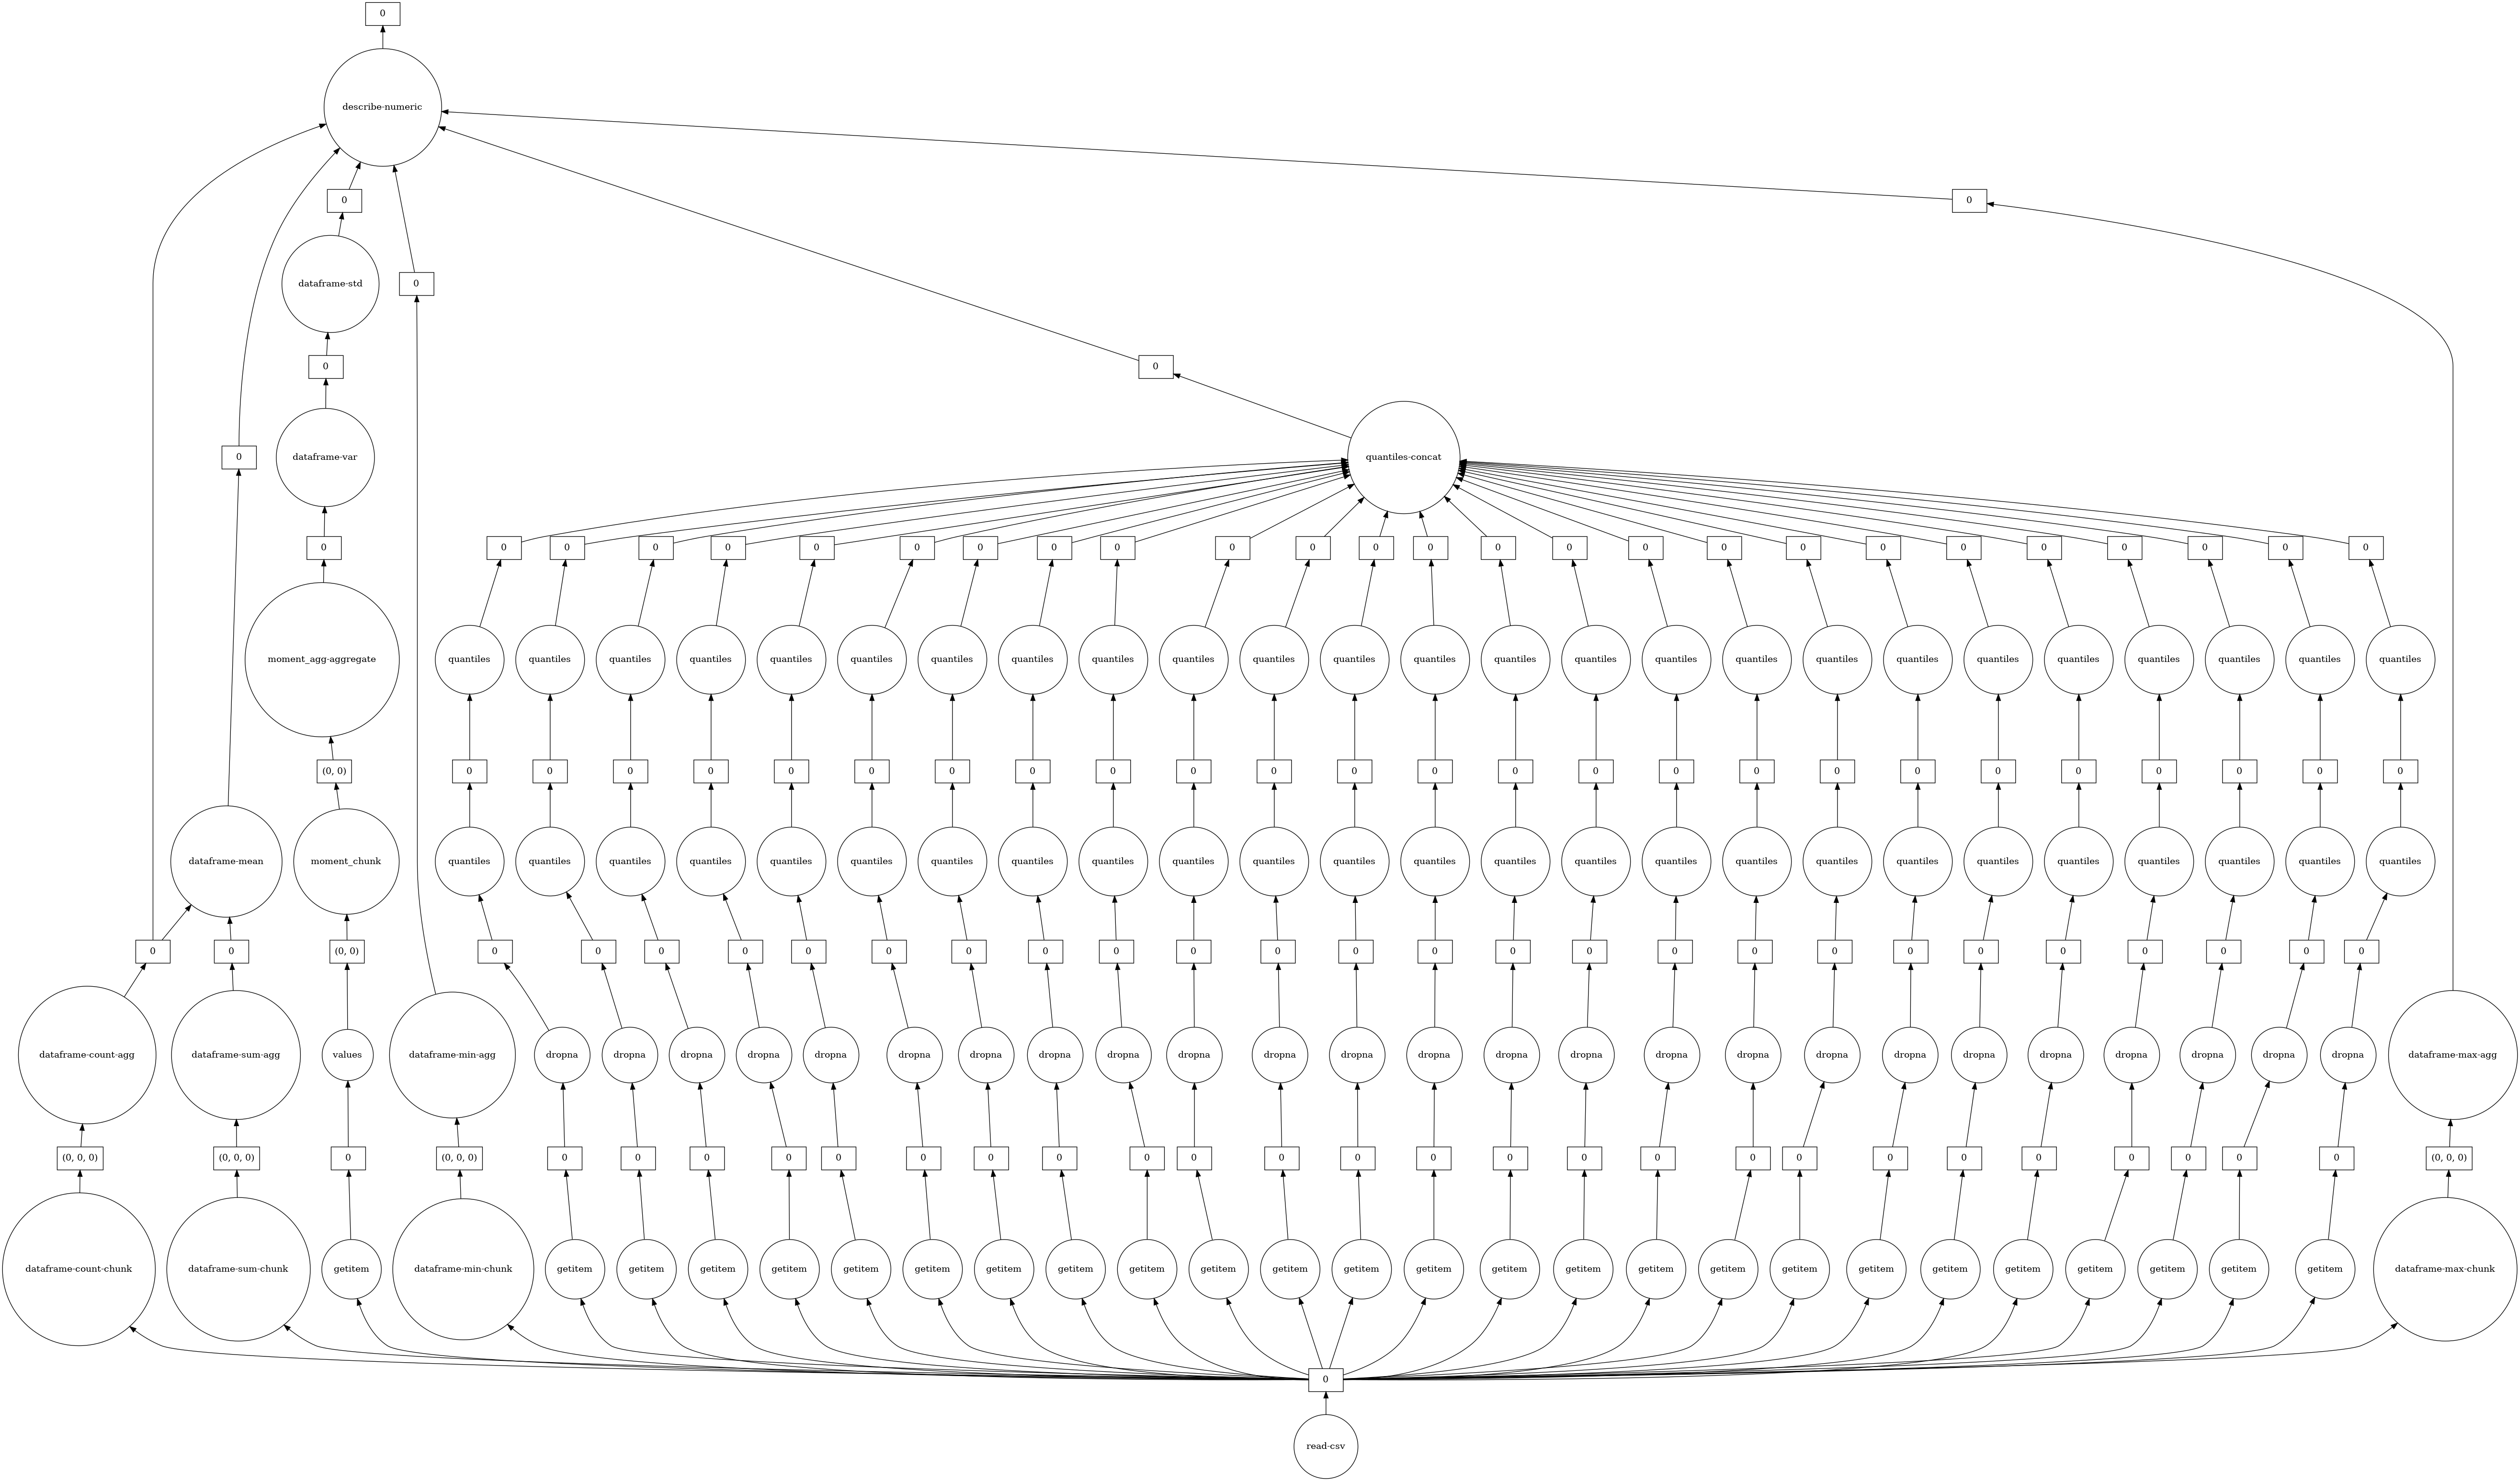

In [ ]:
import dask
dask.visualize(stat)

## Split du jeu de données train/test en 80/20

In [ ]:
!pip install dask_ml

In [ ]:
from dask_ml.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(df.loc[:, df.columns != 'default'], df.default, test_size=0.2, random_state=123, shuffle=False)

## Déclaration d'une régression logistique

Ici il faut utiliser la régression logistique entrainée via la méthode de descente de gradient (SGDClassifier de scikit-learn)

Seuls les paramètres de base sont renseignés, le reste sera ajouté dans le grid search

In [ ]:
from sklearn.linear_model import SGDClassifier
from dask_ml.model_selection import GridSearchCV

model = SGDClassifier(random_state=123, penalty='elasticnet')

## Implémentation du Grid Search

Combiner plusieurs valeurs sur les paramètres : alpha, l1_ratio, eta0 et learning_rate notamment   
Utilisation de 3 cross validation (kfold)

In [ ]:
param_grid = {
    'alpha': [0.1, 1, 3],
    'l1_ratio': [0, 0.5, 1],
    'eta0': [0.1, 1],
    "learning_rate": ["invscaling", "adaptive"],
}

grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, return_train_score=True)

## Entrainement du modèle

In [ ]:
grid_search.fit(train_x, train_y)

GridSearchCV(cv=3,
             estimator=SGDClassifier(penalty='elasticnet', random_state=123),
             param_grid={'alpha': [0.1, 1, 3], 'eta0': [0.1, 1],
                         'l1_ratio': [0, 0.5, 1],
                         'learning_rate': ['invscaling', 'adaptive']},
             return_train_score=True)

## Affichage des meilleurs paramètres et du meilleur score

In [ ]:
grid_search.best_params_, grid_search.best_score_

({'alpha': 3, 'eta0': 1, 'l1_ratio': 0.5, 'learning_rate': 'invscaling'},
 0.7795511221945137)

## Evaluer le modèle sur la fraction de test

In [ ]:
grid_search.score(test_x, test_y)

0.7755892255892256

## Implémentation d'un modèle XGBoost basique

In [ ]:
import xgboost as xgb

model = xgb.dask.XGBClassifier()
model.fit(train_x, train_y)

## Afficher les prédictions sur la fraction de test

In [ ]:
pred = model.predict_proba(test_x)
pred

array([[0.8653017 , 0.1346983 ],
       [0.88857174, 0.11142825],
       [0.97730136, 0.02269864],
       ...,
       [0.8928061 , 0.10719391],
       [0.96975964, 0.03024035],
       [0.673779  , 0.32622096]], dtype=float32)

## Afficher les features importances (graph matplotlib)

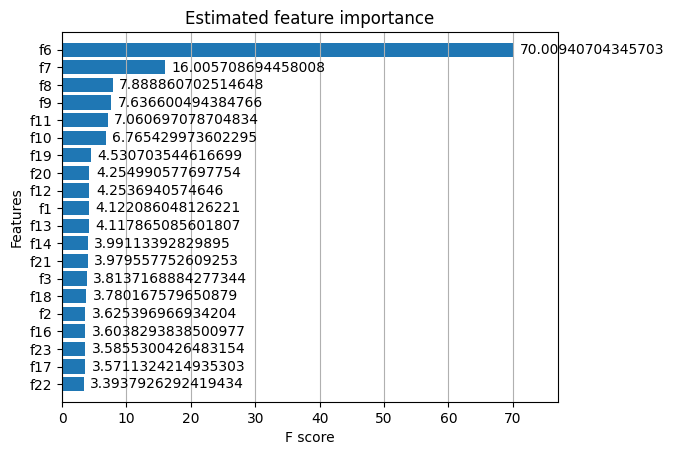

In [ ]:
import xgboost
import matplotlib.pyplot as plt

ax = xgboost.plot_importance(model, height=0.8, max_num_features=20, importance_type="gain")
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
plt.show()

## Afficher la courbe ROC

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(test_y, pred)

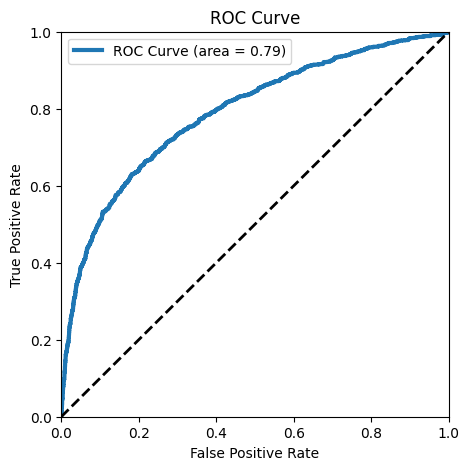

In [ ]:
from sklearn.metrics import auc

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend()
plt.show()

In [ ]:
# Installation de shap (méthode de shapley)
!pip install shap

## Afficher l'interprétation des variables

https://github.com/slundberg/shap
    
### Afficher l'interprétation des variables, seulement pour la première ligne de la fraction test

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_x.compute(), tree_limit=-1)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], feature_names=test_x.columns)

### Afficher l'interprétation des variables, seulement pour la deuxième ligne de la fraction test

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], feature_names=test_x.columns)

### Afficher l'importance moyenne des variables, pour la fraction de test

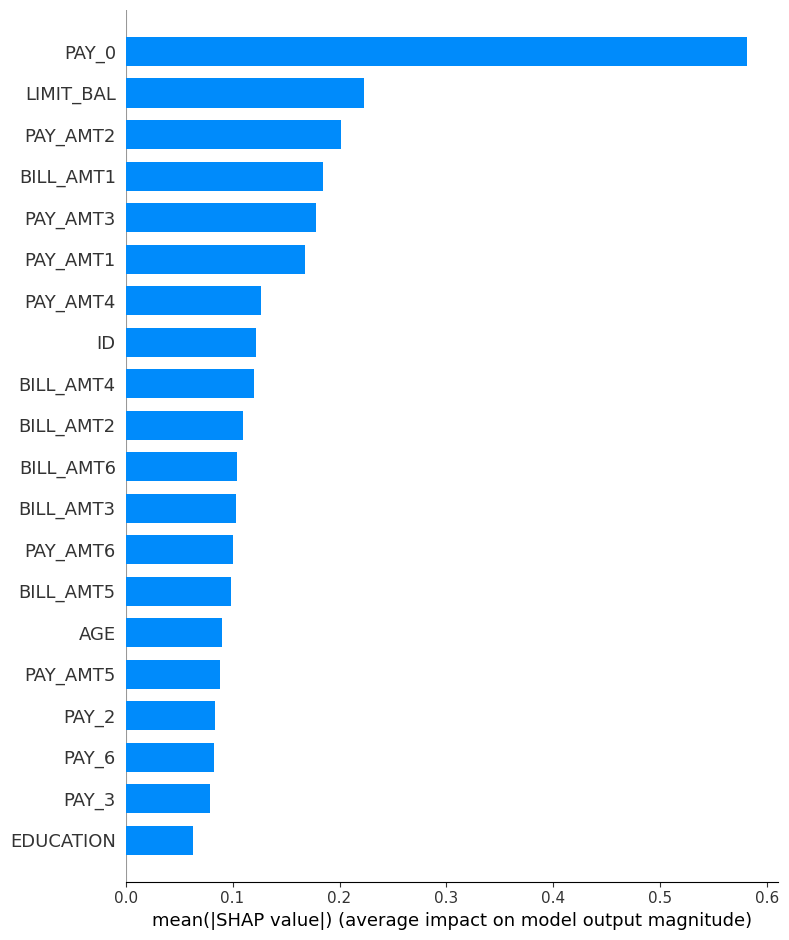

In [ ]:
shap.summary_plot(shap_values, plot_type="bar", feature_names=test_x.columns)

In [ ]:
# Installation de TPOT (AutoML)
!pip install tpot

Solving environment: done

# All requested packages already installed.



## Implémenter l'algorithme TPOT pour générer des pipelines de Machine Learning

Créer 10 générations, d'une population de 5 individus, avec un faible taux de mutation.   
Implémenter l'early stopping, pour que l'entrainement s'arrête si pas d'amélioration après 4 générations.  

http://epistasislab.github.io/tpot/api/

In [ ]:
from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=10, population_size=5, verbosity=3, mutation_rate=0.01, random_state=42, scoring='f1',
                      cv=2, n_jobs=1, use_dask=False, early_stop=4, subsample=0.5)
tpot.fit(train_x.compute(), train_y.compute())

32 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/55 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.46743603611504975	XGBClassifier(input_matrix, XGBClassifier__learning_rate=0.001, XGBClassifier__max_depth=9, XGBClassifier__min_child_weight=7, XGBClassifier__n_estimators=100, XGBClassifier__n_jobs=1, XGBClassifier__subsample=0.45, XGBClassifier__verbosity=0)

Generation 2 - Current Pareto front scores:

-1	0.46743603611504975	XGBClassifier(input_matrix, XGBClassifier__learning_rate=0.001, XGBClassifier__max_depth=9, XGBClassifier__min_child_weight=7, XGBClassifier__n_estimators=100, XGBClassifier__n_jobs=1, XGBClassifier__subsample=0.45, XGBClassifier__verbosity=0)

Generation 3 - Current Pareto front scores:

-1	0.46743603611504975	XGBClassifier(input_matrix, XGBClassifier__learning_rate=0.001, XGBClassifier__max_depth=9, XGBClassifier__min_child_weight=7, XGBClassifier__n_estimators=100, XGBClassifier__n_jobs=1, XGBClassifier__subsample=0.45, XGBClassifier__verbosity=0)

Generation 4 - Current Pareto front scores:

-1	0.4674360361

TPOTClassifier(cv=2, early_stop=4, generations=10, mutation_rate=0.01,
               population_size=5, random_state=42, scoring='f1', subsample=0.5,
               verbosity=3)

### Afficher le score du pipeline retenu, avec la fraction de test

Ensuite, exportez le pipeline sous forme de script Python

In [ ]:
print(tpot.score(test_x.compute(), test_y.compute()))
tpot.export('tpot_pipeline.py')

0.48202137998056366
